# Class 6 - 27.4.20

# Scientific Python and Pandas

Last week we discussed numpy, which in many ways is the cornerstone of the scientific ecosystem of Python. Besides numpy, there are a few additional libraries which every scientific Python user should know. The "epitome" will come in the form of pandas, which will be our main point of interest in the coming lessons.

## Data Visualization - Matplotlib

The most widely-used plotting library in the Python ecosystem is Matplotlib. It has a couple of strong "opponents"\complimentary libraries, in the form of Bokeh and Seaborn, but in terms of raw features it still has no real contenders.

Matplotlib allows for _very_ complicated data visualizations, and has two parallel implementations - a procedural one, and an object-oriented one. The procedural one resembles the MATLAB plotting interface very much, allowing for a very quick transition for MATLAB veterans. Evidently, Matplotlib was initially inspired by MATLAB's approach to visualization.

Having said that, and even though _old habits die hard,_ it's important to stress the point that the object-oriented interface is better in the long run, since it complies with more online examples and allows for easier plot manipulations. Finally, the "best" way to visualize your data will be to coerce it into a Seaborn-like format and use that library to do so. More on that later.

In [1]:
import matplotlib.pyplot as plt  # pyplot is the "scientific" module, 'plt' is the traditional alias
import numpy as np
# for notebooks, not needed for code written somewhere else:
%matplotlib inline 

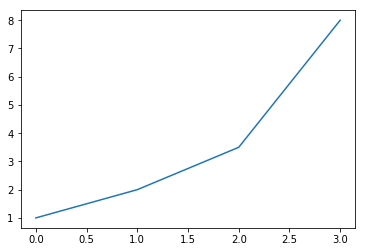

In [2]:
# Procedural implementation - MATLAB style
plt.plot([1, 2, 3.5, 8])

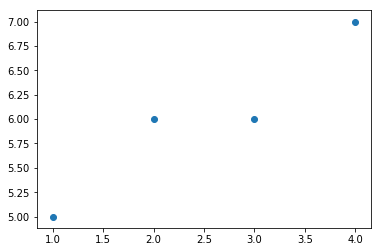

In [3]:
plt.scatter([1, 2, 3, 4], [5, 6, 6, 7])

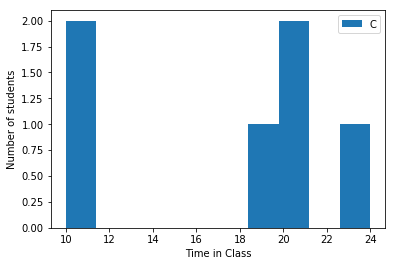

In [4]:
plt.hist(np.array([10, 11, 19, 20, 20, 24]))  # works with lists and numpy arrays
plt.ylabel('Number of students')
plt.xlabel('Time in Class')
plt.legend('C')

But - as we said, this implementation is less ergonomic in the long run. You're better off with the object-oriented one.

Text(0.5, 0, 'Time [seconds]')

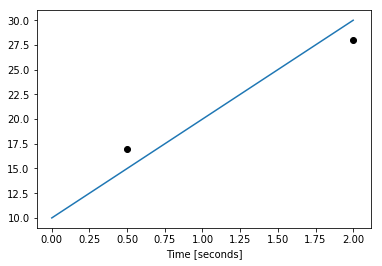

In [5]:
# OO implementation
fig, ax = plt.subplots()
# a figure is the entire "screen" or window, which can contain many plots
# axis is the "container" of data itself. 

# Figures and axes can also be created with the following two lines:
# fig = plt.figure()  
# ax = fig.add_subplot(111)  

# Again, several lines can be contained in the same axis.
ax.plot([10, 20, 30])
ax.scatter([0.5, 2], [17, 28], color='k')
ax.set_xlabel('Time [seconds]')  # the two objects inside the axis object have the same scale

In [6]:
# plots can be saved
fig.savefig("scattered.pdf", dpi=300, transparent=True)

Matplotlib is used in conjuction with numpy to visualize arrays:

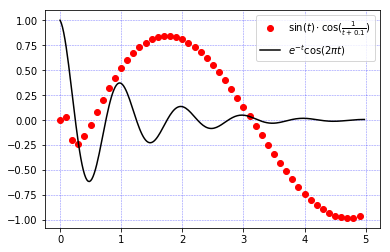

In [7]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)
def g(t):
    return np.sin(t) * np.cos(1/(t+0.1))

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.plot(t1, g(t1), 'ro', t2, f(t2), 'k')  # two plots in the same call
ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

# Assigning labels to each plot (can be done during plotting)
f_label = r'$e^{-t}\cos(2 \pi t)$'
g_label = r'$\sin(t) \cdot \cos(\frac{1}{t + 0.1})$'
ax1.legend([g_label, f_label])

(array([[0., 0., 1., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 3., 3., 2., 1., 0., 1.],
        [0., 2., 4., 1., 2., 2., 2., 1., 1., 1.],
        [0., 1., 0., 2., 2., 3., 2., 0., 1., 1.],
        [0., 4., 4., 2., 0., 2., 5., 3., 0., 0.],
        [0., 0., 4., 4., 5., 2., 0., 1., 1., 0.],
        [1., 1., 1., 2., 1., 2., 2., 0., 0., 0.],
        [0., 0., 2., 2., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.]]),
 array([-2.32643862, -1.85276454, -1.37909046, -0.90541638, -0.4317423 ,
         0.04193178,  0.51560586,  0.98927994,  1.46295402,  1.9366281 ,
         2.41030218]),
 array([-2.02523619, -1.53698173, -1.04872726, -0.5604728 , -0.07221833,
         0.41603613,  0.90429059,  1.39254506,  1.88079952,  2.36905398,
         2.85730845]),
 <matplotlib.collections.QuadMesh at 0x7ffae3859da0>)

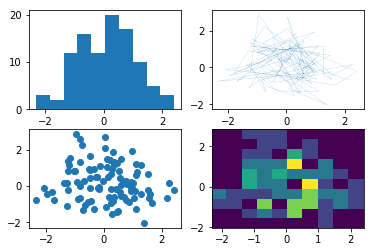

In [8]:
data = np.random.randn(2, 100)  # random numbers from normal distribution

fig, axs = plt.subplots(2, 2)  # two plots per each axis 
axs[0, 0].hist(data[0])
axs[1, 0].scatter(data[0], data[1])
axs[0, 1].plot(data[0], data[1], '-.', linewidth=0.15)
axs[1, 1].hist2d(data[0], data[1])

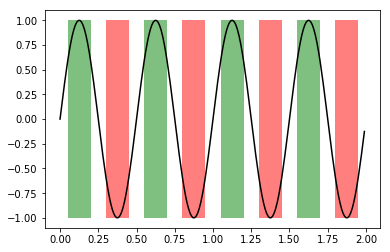

In [9]:
fig, ax = plt.subplots()
x = np.arange(0.0, 2, 0.01)
y = np.sin(4*np.pi*x)
ax.plot(x, y, color='black')

ax.fill_between(x, -1, 1, where=y > 0.5, facecolor='green', alpha=0.5)
ax.fill_between(x, -1, 1, where=y < -0.5, facecolor='red', alpha=0.5)

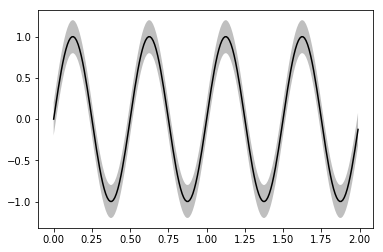

In [10]:
fig, ax = plt.subplots()
x = np.arange(0.0, 2, 0.01)
y = np.sin(4 * np.pi * x)

std = 0.2  # computed value
y_top = y + std
y_bot = y - std
ax.plot(x, y, color='black')

ax.fill_between(x, y_bot, y_top, facecolor='gray', alpha=0.5)

['seaborn-pastel', 'fivethirtyeight', 'seaborn-dark', 'Solarize_Light2', 'seaborn-white', 'seaborn-deep', 'grayscale', 'classic', 'seaborn-paper', 'seaborn-poster', 'seaborn-bright', 'seaborn-ticks', 'bmh', 'seaborn-talk', 'tableau-colorblind10', 'seaborn-notebook', 'seaborn-muted', 'seaborn', 'fast', 'seaborn-dark-palette', 'seaborn-whitegrid', 'seaborn-colorblind', 'ggplot', '_classic_test', 'seaborn-darkgrid', 'dark_background']


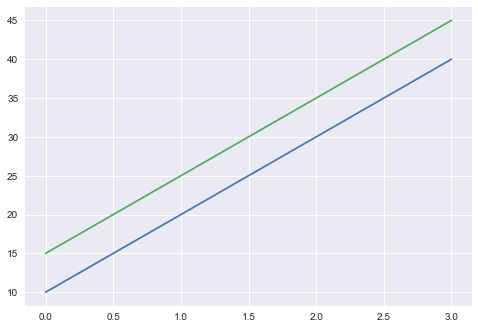

In [11]:
# Styles - a world of possibilities
print(plt.style.available)
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot([10, 20, 30, 40])
ax.plot([15, 25, 35, 45])

## Other Libraries

### SciPy

SciPy is a large library consisting of many smaller modules, each targeting a single field of scientific computing.

Available modules include `scipy.stats`, `scipy.linalg`, `scipy.fftpack`, `scipy.signal` and many more.

Because of its extremely wide scope of available use-cases, we won't go through all of them. All you need to do is to remember that many functions that you're used to find in different MATLAB toolboxes are located somewhere in SciPy. 

Below you'll find a few particularly interesting use-cases.

In [12]:
# .mat files input\output
from scipy import io as spio

a = np.ones((3, 3))

spio.savemat('file.mat', {'a': a})  # savemat expects a dictionary

data = spio.loadmat('file.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Apr 29 15:35:33 2019',
 '__version__': '1.0',
 '__globals__': [],
 'a': array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])}

In [13]:
# Linear algebra
from scipy import linalg

arr = np.arange(9).reshape((3, 3)) + np.diag([1, 0, 1])
uarr, spec, vharr = linalg.svd(arr)  # SVD

arr = np.array([[1, 2],
                [3, 4]])

iarr = linalg.inv(arr)  # Inverse of square matrix
iarr

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

(2.780399133472094, 1.5230340081391265)

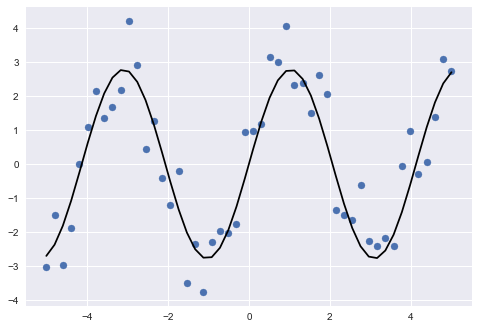

In [14]:
# Curve fitting
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)

# Create noisy data
x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)

fig, ax = plt.subplots()
ax.scatter(x_data, y_data)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data, p0=[3, 1])
ax.plot(x_data, test_func(x_data, params[0], params[1]), 'k')
params[0], params[1]

Ttest_indResult(statistic=-2.4404282931418795, pvalue=0.0162963090927527)

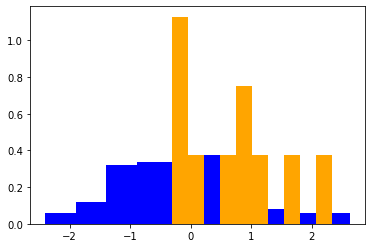

In [5]:
# Statistics
from scipy import stats

a = np.random.normal(loc=0, scale=1, size=100)
b = np.random.normal(loc=1, scale=1, size=10)
fig, ax = plt.subplots()
ax.hist(a, color='b', density=True)
ax.hist(b, color='orange', density=True)
stats.ttest_ind(a, b) 

### IPython

IPython is the REPL in which this text is written in. As stated, it's the most popular "command window" of Python. When most Python programmers wish to write and execute a small Python script, they won't use the regular Python interpreter, accessible with `python my_file.py`. Instead, they will run it with IPython since it has more features. For instance, the popular MATLAB feature which saves the variables that returned from the script you ran is accessible when running a script as `ipython -i my_file.py`.

Let's examine some of IPython's other features, accessible by using the `%` _magic_ operator before writing your actual code:

#### `%%timeit` - micro-benchmarking

In [16]:
def loop_and_sum(lst):
    """ Loop and some a list """
    sum = 0
    for item in lst:
        sum += item

In [17]:
%timeit loop_and_sum([1, 2, 3, 4, 5])

329 ns ± 7.57 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [18]:
%timeit loop_and_sum(list(range(10000)))

700 µs ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### `%%prun` - benchmark each function line

In [19]:
%%prun
data1 = np.arange(500000)
data2 = np.zeros(500000)
ans = data1 + data2 + data1*data2
loop_and_sum(list(np.arange(10000)))
data1 @ data2

### `%run` - run external script

In [20]:
%run mock/a.py

<Figure size 576x396 with 0 Axes>

#### `%matplotlib [notebook\inline]` - show matplotlib figures inside the notebook easily

#### `%reset` - resets the namespace

#### LaTeX support - render the cell as $\LaTeX$

$a^2 + b^2 = c^2$

$e^{i\pi} + 1 = 0$

### Scikit-Image

Scikit-Image is one of the main image processing libraries in Python. We'll look at it in greater interest later in the semester, but for now let's examine some of its algorithms:

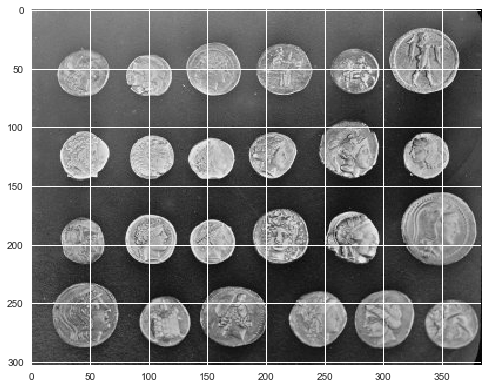

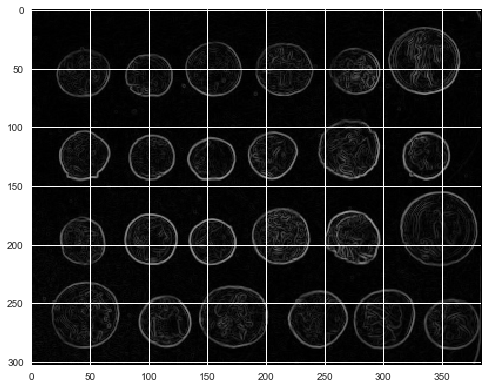

In [21]:
# Edge detection
from skimage import data, io, filters

image = data.coins()
io.imshow(image)
edges = filters.sobel(image)  # edge-detection filter
plt.figure()
io.imshow(edges)

/home/hagaihargil/miniconda3/envs/course/lib/python3.7/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


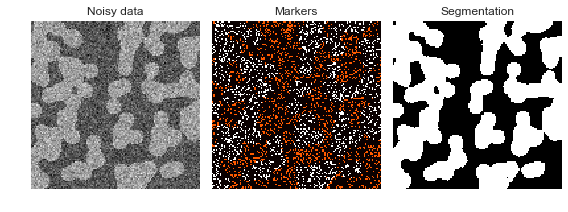

In [22]:
# Segmentation using random walker algorithm
from skimage.segmentation import random_walker
from skimage.data import binary_blobs
import skimage

# Generate noisy synthetic data
data1 = skimage.img_as_float(binary_blobs(length=128, seed=1))  # data
data1 += 0.35 * np.random.randn(*data1.shape)  # added noise
markers = np.zeros(data1.shape, dtype=np.uint)
markers[data1 < -0.3] = 1
markers[data1 > 1.3] = 2

# Run random walker algorithm
labels = random_walker(data1, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data1, cmap='gray', interpolation='nearest')
ax1.axis('off')
ax1.set_adjustable('box-forced')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='hot', interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box-forced')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray', interpolation='nearest')
ax3.axis('off')
ax3.set_adjustable('box-forced')
ax3.set_title('Segmentation')

fig.tight_layout()

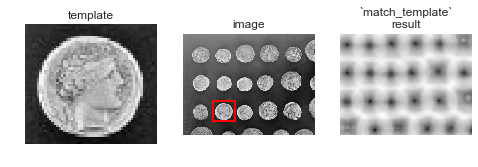

In [23]:
# Template matching

from skimage.feature import match_template


image = skimage.data.coins()
coin = image[170:220, 75:130]

result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2, adjustable='box-forced')

ax1.imshow(coin, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none', linewidth=2)
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

### Exercise

Perform these exercises using the object-oriented interface of Matplotlib. Search for the proper methods from the different SciPy and Matplotlib modules.

1. Create 1000 normally-distributed points. Histogram them. Overlay the histogram with a dashed line showing the theoretical normal distribution we would expect from the data.
2. Create a (1000, 3)-shaped matrix of uniformly distributed points between [0, 1). Create a scatter plot with the first two columns as the $x$ and $y$ columns, while the third should control the size of the created point.

3. Using `np.random.choice`, "roll a die" 100 times. Create a 6x1 figure panel with a shared $x$-axis containing values between 0 and 10000 (exclusive). The first panel should show a vector with a value of 1 everywhere the die roll came out as 1, and 0 elsewhere. The second panel should show a vector with a value of 1 everywhere the die roll came out as 2, and 0 elsewhere, and so on. Create a title for the entire figure. The $y$-axis of each panel should indicate the value this plot refers to.

### Exercise solutions below...

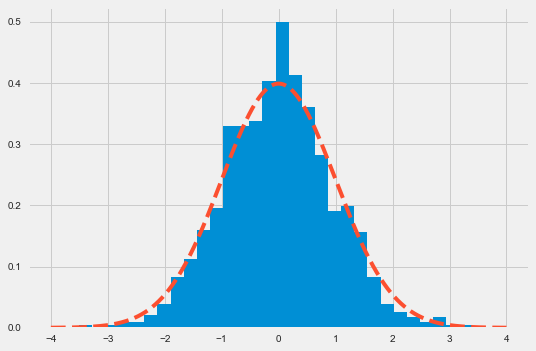

In [24]:
# 1
plt.style.use('fivethirtyeight')
import scipy.stats

data = np.random.randn(1000)
x_axis = np.arange(-4, 4, 0.001)

fig, ax = plt.subplots()
ax.hist(data, bins=30, density=True)  # the "density" keyword simplifies the scaling
ax.plot(x_axis, scipy.stats.norm.pdf(x_axis, 0, 1), '--')

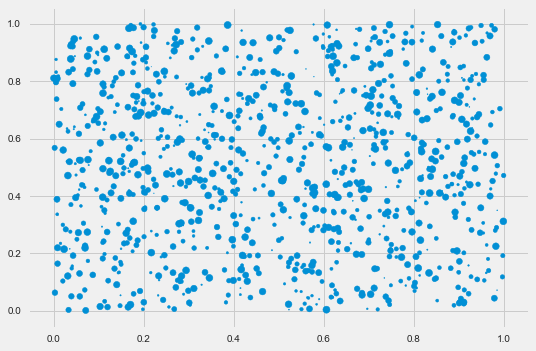

In [25]:
# 2
data = np.random.random((1000, 3))
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=data[:, 2]*50)

Text(0.01, 0.5, 'Roll value')

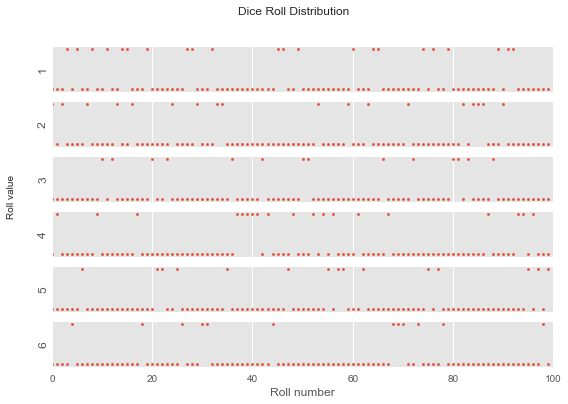

In [26]:
# 3
plt.style.use('ggplot')
die = np.arange(1, 7)
num = 100
rolls = np.random.choice(die, num)
fig, ax = plt.subplots(6, 1, sharex=True)
for roll, axis in enumerate(ax, 1):
    axis.scatter(np.arange(num), rolls==roll, s=5)  # notice how we plot a boolean vector
    axis.set_ylabel(roll)
    axis.yaxis.set_ticks([])

axis.set_xlim([0, num])
axis.set_xlabel('Roll number')
fig.suptitle('Dice Roll Distribution')
fig.text(0.01, 0.5, 'Roll value', ha='center', va='center', rotation='vertical')

## Pandas - Data Analysis in Python

A large part of what makes Python so popular nowadays is Pandas, or the "Python data analysis library".

Pandas has been around since 2008, and while in itself it's built on the solid foundations of numpy, it introduced a vast array of important features that can hardly be found anywhere _outside_ of the Python ecosystem.

The general priniciple in working with Pandas is to first look up in its immense codebase (via its docs), or somewhere online, an existing function that does exactly what you're looking for, and if you can't - only then should you implement it youself.

Much of the discussion below is taken from the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/), by Jake VanderPlas. Be sure to check it out if you need further help with one of the topics.

## The need for pandas

With only _clean_ data in the world, pandas wouldn't be as necessary. By clean we mean that all of our data was sampled properly, without any missing data points. We also mean that the data is homogeneous, i.e. of a single type (floats, ints), and one-dimensional. 

An example of this simple data might be an electrophysiological measurement of a neuron's votlage over time, a calcium trace of a single imaged neuron and other simple cases such as these.

Pandas provide flexibility for our numerical computing tasks via its two main data types: `DataFrame` and `Series`, which are multi-puporse data containers with very useful features, which you'll soon learn about.

Mastering pandas is one of the most important goals of this course. Your work as scientists will be _greatly_ simplified if you'll feel comfortable in the pandas jungle.

## Series

A pandas series is generalization of a simple numpy array. It's the basic building block of pandas objects.

In [27]:
import numpy as np
import pandas as pd  # customary import
import matplotlib.pyplot as plt

In [28]:
# Starting of with a Series - a one-dimensional data container
ser = pd.Series([50., 100., 150., 200.])  # the first argument is the data argument, list-like, just like for numpy
ser

0     50.0
1    100.0
2    150.0
3    200.0
dtype: float64

We received a Series with our values and an associated index. The index was given automatically, and it defaults to ordinal numbers. Notice how the data is displayed as a column. This is because the pandas library deals with tabular data. 

We can access the internal arrays - data and indices - by using the `array` and `index` attributes:

In [29]:
ser.array  # a PandasArray is almost always identical to a numpy array (it's a wrapper)

<PandasArray>
[50.0, 100.0, 150.0, 200.0]
Length: 4, dtype: float64

Note that in many places you'll see `ser.values` used when trying to access the raw data. This is no longer encouraged, and you should generally use either `ser.array` or `ser.to_numpy()`.

In [30]:
ser.index  # special pandas index object

RangeIndex(start=0, stop=4, step=1)

The index of the array is a true __index__, just like that of a dictionary, making item access pretty intuitive:

In [31]:
ser[1]

100.0

In [32]:
ser[:3]  # non-inclusive index

0     50.0
1    100.0
2    150.0
dtype: float64

While this feature is very similar to a Numpy array's index, a Series can also have non-integer indices:

In [33]:
data = pd.Series([1, 2, 3, 4], index=['a', 'b', 'c', 'd'])
data

a    1
b    2
c    3
d    4
dtype: int64

In [34]:
data['c']  # as expected

3

In [35]:
data2 = pd.Series(10, index=['first', 'second', 'third'])
data2

first     10
second    10
third     10
dtype: int64

The index of a series is one of its most important features. It also strengthens the analogy of a series to an enhanced Python dictionary. The main difference between a series and a dictionary lies in its _vectorization_ - data inside a series can be processed in a vectorized manner, just like you would act upon a standard numpy array.

### Construction of a Series

In [36]:
# Simplest form
ser = pd.Series([1, 2, 3])
ser  # indices and dtype inferred

0    1
1    2
2    3
dtype: int64

In [37]:
# Very similar
ser = pd.Series(np.arange(10, 20, dtype=np.uint8))
ser

0    10
1    11
2    12
3    13
4    14
5    15
6    16
7    17
8    18
9    19
dtype: uint8

In [38]:
# Index can be specified, as we've seen
ser = pd.Series(['a', 'b', 'c'], index=['A', 'B', 'C'])
ser  # dtype is "object", due to the underlying numpy array

A    a
B    b
C    c
dtype: object

In [39]:
# A series (and a DataFrame) can be composed out of a dictionary as well:
cont_dict = dict(Europe=10, Africa=21, America=9, Asia=9, Australia=19)
cont_ser = pd.Series(cont_dict)
cont_ser

Europe       10
Africa       21
America       9
Asia          9
Australia    19
dtype: int64

Notice how the index is already sorted alphabetically, and that the right `dtype` was inferred automatically. 

When creating a series from a dictionary, the importance of the index is revealed again:

In [40]:
ser1 = pd.Series({'a': 1, 'b': 2, 'c': 3}, index=['a', 'b'])
print(f"Indices override the data:\n{ser1}")

ser2 = pd.Series({'a': 1, 'b': 2, 'c':3}, index=['a', 'b', 'c', 'd'])
print(f"Indices can add NaNs:\n{ser2}")

Indices override the data:
a    1
b    2
dtype: int64
Indices can add NaNs:
a    1.0
b    2.0
c    3.0
d    NaN
dtype: float64


We can also use slicing on these non-numeric indices:

In [41]:
print(cont_ser)
print("-----")
cont_ser['America':'Australia']  # INCLUSIVE LAST INDEX (in this case) - string indices are inclusive on both ends
# this makes more sense when using location-based indices, since in day-to-day speak we regulary talk with
# "inclusive" indices - "hand me over the tests of students 1-5" obviously refers to 5 students, not 4.

Europe       10
Africa       21
America       9
Asia          9
Australia    19
dtype: int64
-----


America       9
Asia          9
Australia    19
dtype: int64

We'll dicuss pandas indexing extensively later on, but I do want to point out now that indexes can be non-unique:

In [42]:
ser = pd.Series(np.arange(5), index=[1, 1, 2, 2, 3])
ser

1    0
1    1
2    2
2    3
3    4
dtype: int64

A few operations require a unique index, making them raise an exception - but most operations should work seamlessly.

Lastly, series objects can have a name attached to them as well:

In [43]:
ser_named = pd.Series([1, 2, 3], name='Data')
ser_unnamed = pd.Series([2, 3, 4])
ser_unnamed.rename("Unnamed")

0    2
1    3
2    4
Name: Unnamed, dtype: int64

## DataFrame

A `pd.DataFrame` is a concatenation of multiple `Series` objects that share the same index. It's a generalization of a two dimensional Numpy array.

You can also think of it as a dictionary of `pd.Series` objects, as a database table, or a spreadsheet.

Due to its flexibility, `pd.DataFrame` is the more widely used data structure.

In [44]:
# First we define a second series
cont_pop = pd.Series(dict(Europe=100., Africa=907.8, America=700.1, Asia=2230., Australia=73.7))
cont_pop

Europe        100.0
Africa        907.8
America       700.1
Asia         2230.0
Australia      73.7
dtype: float64

In [45]:
olympics_df = pd.DataFrame({'population': cont_pop, 'medals': cont_ser})
olympics_df

,population,medals
Europe,100.0,10
Africa,907.8,21
America,700.1,9
Asia,2230.0,9
Australia,73.7,19


In [46]:
# A dataframe has a row index ("index") and a column index (columns)
print(olympics_df.index)
# And the columns
print(olympics_df.columns)  # new

Index(['Europe', 'Africa', 'America', 'Asia', 'Australia'], dtype='object')
Index(['population', 'medals'], dtype='object')


### Construction

Creating a DataFrame can be done in one of several ways:
- Dictionary of 1D numpy arrays, lists, dictionaries or Series.
- A 2D numpy array.
- A Series
- A different DataFrame.

Alongside the data itself, you can pass two important arguments to the constructor:
- `columns` - An iterable of the headers of each data column.
- `index` - Similar to a series.

Just like in the Series case, passing these arguments ensures that the resulting DataFrame will contain these specific columns and indices, which might lead to NaNs in certain rows and\or columns.

In [47]:
d = {'one' : pd.Series([1., 2., 3.], index=['a', 'b', 'c']),
     'two' : pd.Series([1., 2., 3., 4.], index=['a', 'b', 'c', 'd'])}

df = pd.DataFrame(d)
df

,one,two
a,1.0,1.0
b,2.0,2.0
c,3.0,3.0
d,NaN,4.0


In [48]:
# A row is dropped since one of the indices was unspecified
pd.DataFrame(d, index=['d', 'b', 'a'])

,one,two
d,NaN,4.0
b,2.0,2.0
a,1.0,1.0


In [49]:
# A column of NaNs is forced
pd.DataFrame(d, index=['d', 'b', 'a'], columns=['two', 'three'])

,two,three
d,4.0,NaN
b,2.0,NaN
a,1.0,NaN


In [50]:
# A 1D dataframe is also possible
df1d = pd.DataFrame([1, 2, 3], columns=['data'])  # notice the iterable in the columns argument
df1d

,data
0,1
1,2
2,3


In [51]:
df_from_array = pd.DataFrame((np.random.random((2, 10))))
df_from_array

,0,1,2,3,4,5,6,7,8,9
0,0.662158,0.401426,0.826174,0.856610,0.596255,0.626376,0.557250,0.425609,0.320572,0.769008
1,0.572535,0.364969,0.478858,0.178292,0.101856,0.007783,0.617719,0.615681,0.720372,0.696361


## Columnar operations

If we continue with the dictionary analogy, we can observe how intuitive the operations on series and dataframe columns can be:

In [52]:
olympics_df

,population,medals
Europe,100.0,10
Africa,907.8,21
America,700.1,9
Asia,2230.0,9
Australia,73.7,19


In [53]:
# DataFrame can be thought of as a dict. Thus, accessing a column is done in the following manner:
olympics_df['population']  # a column of a dataframe is a series object

Europe        100.0
Africa        907.8
America       700.1
Asia         2230.0
Australia      73.7
Name: population, dtype: float64

This will definitely be one of your main sources of confusion - in a 2D array, `arr[0]` will return the first _row_. In a dataframe, `df['col0']` will return the first column. Thus, the dictionary analogy might be better suited for indexing operations.

To show a few operations on a dataframe, let's remind ourselves of the `df` variable:

In [54]:
df

,one,two
a,1.0,1.0
b,2.0,2.0
c,3.0,3.0
d,NaN,4.0


In [55]:
# First we see that we can access columns using standard dot notation as well (although it's usually not recommended):
df.one

a    1.0
b    2.0
c    3.0
d    NaN
Name: one, dtype: float64

In [56]:
# Can you guess what will these two operations do?
df['three'] = df['one'] * df['two']

df['flag'] = df['one'] > 2

In [57]:
df

,one,two,three,flag
a,1.0,1.0,1.0,False
b,2.0,2.0,4.0,False
c,3.0,3.0,9.0,True
d,NaN,4.0,NaN,False


In [58]:
# Columns can be deleted with del, or popped like a dictionary:
three = df.pop('three')
three

a    1.0
b    4.0
c    9.0
d    NaN
Name: three, dtype: float64

In [59]:
# Insertion of some scalar value will propagate throughout the column:
df['foo'] = 'bar'
df

,one,two,flag,foo
a,1.0,1.0,False,bar
b,2.0,2.0,False,bar
c,3.0,3.0,True,bar
d,NaN,4.0,False,bar


In [60]:
# Indices are powerful. Trying to push data witha different index will result in NaNs:
df['one_trunc'] = df.one[:2]
df
# You can, of course, insert raw numpy arrays, but then their length must exactly match that
# of the original dataframe.

,one,two,flag,foo,one_trunc
a,1.0,1.0,False,bar,1.0
b,2.0,2.0,False,bar,2.0
c,3.0,3.0,True,bar,NaN
d,NaN,4.0,False,bar,NaN


#### The `assign` method

In [61]:
# There's a more powerful way to insert a column into a dataframe, using the assign method:
olympics_df 

,population,medals
Europe,100.0,10
Africa,907.8,21
America,700.1,9
Asia,2230.0,9
Australia,73.7,19


In [62]:
# This is a straight-forward assignment that could've been done in a simpler manner, as shown three cells above
olympics_df_new = olympics_df.assign(
    rel_medals=
        olympics_df['population']/olympics_df['medals']
)
olympics_df_new  # copy of olympics_df

,population,medals,rel_medals
Europe,100.0,10,10.000000
Africa,907.8,21,43.228571
America,700.1,9,77.788889
Asia,2230.0,9,247.777778
Australia,73.7,19,3.878947


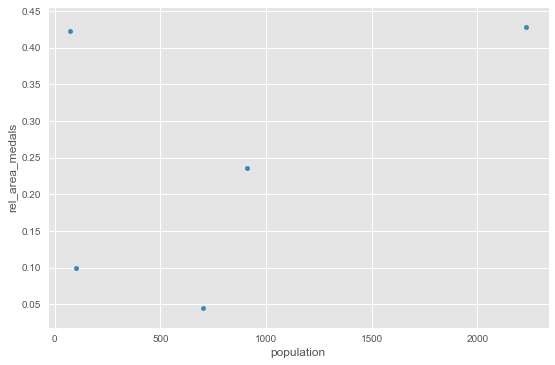

In [63]:
# But assign() can also help us do more complicated stuff:
# We create a intermediate dataframe and run the calculations on it
(olympics_df_new.assign(area=[100, 89, 200, 21, 45])
    .assign(rel_area_medals=lambda x: x.medals/x.area)
    .plot(kind='scatter', x='population', 
          y='rel_area_medals'))
plt.show()

[

The `lambda` expression is an anonymous function (like MATLAB's `@` symbol) and its argument `x` is the intermediate DataFrame we're handling. A simpler example might look like:

```python
y = lambda x: x + 1
y(3) == 4
```
]

## Indexing

pandas indexing can be seem complicated at times due to its high flexibility. However, its relative importance should motivate you to overcome this initial barrier.

The pandas documentation summarizes it in the following manner:

|Operation|Syntax|Result|
|--------|-------|------|
|Select column| `df[col], df.col` | Series|
|Select row by label| `df.loc[row_label]` | Series|
|Select row by integer location| `df.iloc[intloc]` | Series|
|Slice rows| `df[5:10]` | DataFrame|
|Select rows by boolean vector| `df[bool_vec]` or `df.loc[bool_vec]` or `df.iloc[bool_vec]` | DataFrame|

Another helpful summary is the following:
>Like lists, you can index by integer position (`df.iloc[intloc]`).

>Like dictionaries, you can index by label (`df[col]` or `df.loc[row_label]`).

>Like NumPy arrays, you can index with boolean masks (`df[bool_vec]`).

>Any of these indexers could be scalar indexes, or they could be arrays, or they could be slices.

>Any of these should work on the index (=row labels) or columns of a DataFrame.

>And any of these should work on hierarchical indexes (we'll discuss hierarchical indices later).


In [64]:
# Let's see what all the fuss is about:
df

,one,two,flag,foo,one_trunc
a,1.0,1.0,False,bar,1.0
b,2.0,2.0,False,bar,2.0
c,3.0,3.0,True,bar,NaN
d,NaN,4.0,False,bar,NaN


#### `.loc`
`.loc` is primarily label based, but may also be used with a boolean array. .loc will raise KeyError when the items are not found. Allowed inputs are:

- A single label, e.g. 5 or 'a', (note that 5 is interpreted as a label of the index. This use is not an integer position along the index)

- A list or array of labels ['a', 'b', 'c']

- A slice object with labels `'a':'f'` (note that contrary to usual python slices, both the start and the stop are included, when present in the index! - also see Slicing with labels)

- A boolean array

- A callable function with one argument (the calling Series, DataFrame or Panel) and that returns valid output for indexing (one of the above)

In [65]:
df.loc['a']  # a series is returned

one              1
two              1
flag         False
foo            bar
one_trunc        1
Name: a, dtype: object

In [66]:
df.loc['a':'b']  # two items!
# Using characters is always inclusive on both ends. This is because it's more "natural" this way, according to
# pandas devs. As natural as it may be, it's definitely confusing.

,one,two,flag,foo,one_trunc
a,1.0,1.0,False,bar,1.0
b,2.0,2.0,False,bar,2.0


In [67]:
df.loc[[True, False, True, False]]

,one,two,flag,foo,one_trunc
a,1.0,1.0,False,bar,1.0
c,3.0,3.0,True,bar,NaN


#### `.iloc`
`.iloc` is primarily integer position based (from 0 to length-1 of the axis), but may also be used with a boolean array. `.iloc` will raise IndexError if a requested indexer is out-of-bounds, except slice indexers which allow out-of-bounds indexing. (this conforms with Python/numpy slice semantics). Allowed inputs are:

- An integer, e.g. `5`

- A list or array of integers `[4, 3, 0]`

- A slice object with ints `1:7`

- A boolean array

- A callable function with one argument (the calling Series, DataFrame or Panel) and that returns valid output for indexing (one of the above)

In [68]:
df.iloc[1:3]

,one,two,flag,foo,one_trunc
b,2.0,2.0,False,bar,2.0
c,3.0,3.0,True,bar,NaN


In [69]:
df.iloc[[True, False, True, False]]

,one,two,flag,foo,one_trunc
a,1.0,1.0,False,bar,1.0
c,3.0,3.0,True,bar,NaN


In [70]:
# We note that we can also slice rows in a more intuitive fashion:
df[1:10]

,one,two,flag,foo,one_trunc
b,2.0,2.0,False,bar,2.0
c,3.0,3.0,True,bar,NaN
d,NaN,4.0,False,bar,NaN


Notice how no exception was raised even though we tried to slice _outside_ the DF boundary. This conforms to standard Python and numpy behavior.

This slice notation (without `.iloc` or `.loc`) works fine, but it sometimes counter-intuitive. Try this example:

In [101]:
df2 = pd.DataFrame([[1, 2, 3, 4], [5, 6, 7, 8]], columns=['A', 'B', 'C', 'D'], index=[10, 20])
df2

,A,B,C,D
10,1,2,3,4
20,5,6,7,8


In [102]:
df2[1:]  # we succeed with slicing

,A,B,C,D
20,5,6,7,8


In [104]:
df2[1]  # we fail, since the key "1" isn't in the columns
# df2[10] - this also fails

KeyError: 1

This is why we generally prefer indexing with either `.loc` or `.iloc` - we know what we're after, and we explicitly write it.

## Exercise

1. Basics #1:
    - Create a mock `pd.Series` containing the number of autonomous cars in different cities in Israel. Use proper naming and datatypes, and have at least 7 data points.
    - Show the mean, standard deviation and median of the Series.
    - Create another mock Series for the population counts of the cities you used in question 1.
    - Make a DataFrame from both series and plot (scatter plot) the number of autonomous cars as a function of the population using the pandas' API only, without a direct call to matplotlib (besides `plt.show()`).
    
1. Basics #2:
    - Create three random `pd.Series` and generate a `pd.DataFrame` from them. Name each series, but make sure to use the same, non-numeric, index for the different series. 
    - Display the underlying numpy array.
    - Create a new column from the addition of two of the columns without the `assign()` method.
    - Create a new column from the multiplication of two of the columns using `assign()`, and plot the result.
    - Take the sine of the entire DF.

2. Dates and times in pandas:
    - Create a DataFrame with at least two columns, a _datetime index_ (look at `pd.date_range`) and random data. 
    - Convert the dtype of one of the columns (int <-> float).
    - View the top and bottom of the dataframe using the `head` and `tail` methods. Make sure to visit `describe()` as well.
    - Use the `sort_value` by column values to sort your DF. What happened to the indices?
    - Re-sort the dataframe with the `sort_index` method.
    - Display the value in the third row, at the second column. What's the most well suited indexing method?
   
3. DataFrame comparisons and operations:
    - Generate another DataFrame with at least two columns. Populate it with random values between -1 and 1.
    - Find the places where the dataframe contains negative values, and replace them with their positive inverse (-0.21 turns to 0.21). 
    - Set one of the values to NaN using `.loc`.
    - Drop the entire column containing this null value.

### Exercise solutions below...

#### 1

In [78]:
import numpy as np
import pandas as pd

In [79]:
data = {'Tel Aviv': 123,
        'Jerusalem': 115,
        'Haifa': 80,
        'Beer Sheva': 95,
        'Rishon Lezion': 70,
        'Netanya': 70,
        'Petah Tikva': 62}
cars_ser = pd.Series(data, name='autocars')  # dtype is int64 automatically
cars_ser.describe()


count      7.000000
mean      87.857143
std       23.772733
min       62.000000
25%       70.000000
50%       80.000000
75%      105.000000
max      123.000000
Name: autocars, dtype: float64

In [80]:
population = {'Tel Aviv': 750.2,
              'Jerusalem': 900.,
              'Haifa': 700.9,
              'Beer Sheva': 650.4,
              'Rishon Lezion': 561.6,
              'Netanya': 400.6,
              'Petah Tikva': 390.1}
pop_ser = pd.Series(population, name='population')
pop_ser

Tel Aviv         750.2
Jerusalem        900.0
Haifa            700.9
Beer Sheva       650.4
Rishon Lezion    561.6
Netanya          400.6
Petah Tikva      390.1
Name: population, dtype: float64

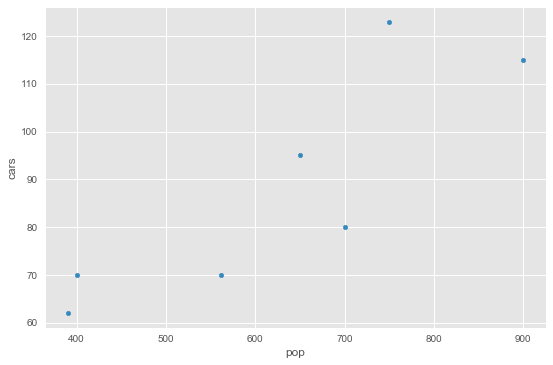

In [81]:
df_auto = pd.DataFrame({'cars': cars_ser, 'pop': pop_ser})
df_auto.plot(x='pop', y='cars', kind='scatter')

#### 2

In [82]:
import string

data = np.random.random((3, 10))
col0, col1, col2 = data  # unpacking

index = list(string.ascii_lowercase[:10])
ser0 = pd.Series(col0, index=index, name='one')
ser1 = pd.Series(col1, index=index, name='two')
ser2 = pd.Series(col2, index=index, name='three')
ser2

a    0.859326
b    0.350401
c    0.061761
d    0.349676
e    0.307471
f    0.555746
g    0.321835
h    0.060662
i    0.159401
j    0.398049
Name: three, dtype: float64

In [83]:
df_from_series = pd.DataFrame({ser0.name: ser0, ser1.name: ser1, ser2.name: ser2})
df_from_series

,one,two,three
a,0.223541,0.279848,0.859326
b,0.602568,0.036585,0.350401
c,0.700834,0.052318,0.061761
d,0.073837,0.781083,0.349676
e,0.571036,0.573645,0.307471
f,0.677481,0.822206,0.555746
g,0.728826,0.454199,0.321835
h,0.020702,0.629961,0.060662
i,0.143928,0.021737,0.159401
j,0.736501,0.481568,0.398049


In [84]:
df_from_series['four'] = df_from_series.one + df_from_series.three
df_from_series

,one,two,three,four
a,0.223541,0.279848,0.859326,1.082866
b,0.602568,0.036585,0.350401,0.952969
c,0.700834,0.052318,0.061761,0.762594
d,0.073837,0.781083,0.349676,0.423513
e,0.571036,0.573645,0.307471,0.878506
f,0.677481,0.822206,0.555746,1.233227
g,0.728826,0.454199,0.321835,1.050661
h,0.020702,0.629961,0.060662,0.081363
i,0.143928,0.021737,0.159401,0.303329
j,0.736501,0.481568,0.398049,1.134550


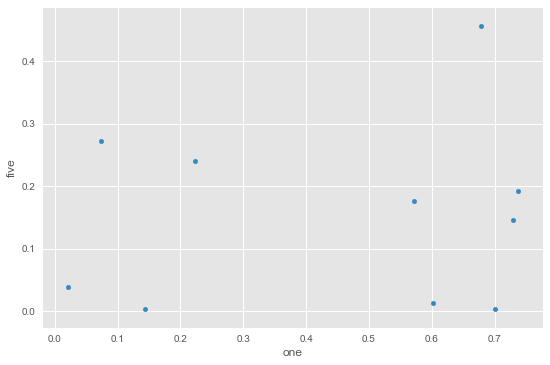

In [85]:
df_from_series.assign(five=df_from_series.two * df_from_series.three).plot(kind='scatter', x='one', y='five')

In [86]:
np.sin(df_from_series)  # no need for data transformations, or to use the `.to_numpy()` method

,one,two,three,four
a,0.221684,0.276209,0.757402,0.883305
b,0.566760,0.036577,0.343274,0.815139
c,0.644855,0.052294,0.061721,0.690800
d,0.073770,0.704049,0.342593,0.410965
e,0.540504,0.542697,0.302649,0.769786
f,0.626833,0.732649,0.527577,0.943563
g,0.665994,0.438743,0.316308,0.867752
h,0.020700,0.589113,0.060625,0.081274
i,0.143432,0.021735,0.158727,0.298699
j,0.671700,0.463169,0.387621,0.906344


#### 3

In [87]:
dates = pd.date_range(start='20180101', periods=6, freq='M')
dates  # examine the dates we were given

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30'],
              dtype='datetime64[ns]', freq='M')

In [88]:
df = pd.DataFrame(np.random.randn(6,4), index=dates, columns=list('A B C D'.split()))
df.loc['20180331', 'C'] = np.nan
df

,A,B,C,D
2018-01-31,-0.304741,-1.304132,-0.854848,-1.550153
2018-02-28,0.913421,-0.342893,1.912155,1.698049
2018-03-31,0.792131,-0.798462,NaN,1.521477
2018-04-30,0.768950,-1.165213,-0.770904,-0.449048
2018-05-31,-0.542440,1.749255,2.237774,0.760332
2018-06-30,-1.727627,0.762635,1.274372,-0.156952


In [89]:
df.A = df.A.astype(int)
df.head(3)  # shows the 3 top entries. df.tail() also works

,A,B,C,D
2018-01-31,0,-1.304132,-0.854848,-1.550153
2018-02-28,0,-0.342893,1.912155,1.698049
2018-03-31,0,-0.798462,NaN,1.521477


In [90]:
df.describe()

,A,B,C,D
count,6.000000,6.000000,5.000000,6.000000
mean,-0.166667,-0.183135,0.759710,0.303951
std,0.408248,1.204481,1.477097,1.253101
min,-1.000000,-1.304132,-0.854848,-1.550153
25%,0.000000,-1.073525,-0.770904,-0.376024
50%,0.000000,-0.570678,1.274372,0.301690
75%,0.000000,0.486253,1.912155,1.331191
max,0.000000,1.749255,2.237774,1.698049


In [91]:
# When we sort the dataframe by the values, the indices must stay with the data! That's the point.
df.sort_values(by='C', inplace=True, na_position='last')  # ascending by default, place the nans at the end
df

,A,B,C,D
2018-01-31,0,-1.304132,-0.854848,-1.550153
2018-04-30,0,-1.165213,-0.770904,-0.449048
2018-06-30,-1,0.762635,1.274372,-0.156952
2018-02-28,0,-0.342893,1.912155,1.698049
2018-05-31,0,1.749255,2.237774,0.760332
2018-03-31,0,-0.798462,NaN,1.521477


In [92]:
df2 = df.copy()
df2.sort_index()

,A,B,C,D
2018-01-31,0,-1.304132,-0.854848,-1.550153
2018-02-28,0,-0.342893,1.912155,1.698049
2018-03-31,0,-0.798462,NaN,1.521477
2018-04-30,0,-1.165213,-0.770904,-0.449048
2018-05-31,0,1.749255,2.237774,0.760332
2018-06-30,-1,0.762635,1.274372,-0.156952


In [93]:
df2  # unsorted, because we haven't used the inplace keyword

,A,B,C,D
2018-01-31,0,-1.304132,-0.854848,-1.550153
2018-04-30,0,-1.165213,-0.770904,-0.449048
2018-06-30,-1,0.762635,1.274372,-0.156952
2018-02-28,0,-0.342893,1.912155,1.698049
2018-05-31,0,1.749255,2.237774,0.760332
2018-03-31,0,-0.798462,NaN,1.521477


In [94]:
# Third row, second column
df2.iloc[2, 1]

0.7626354590491697

In [95]:
ran = np.random.random((10))
ran.std()

0.3204415555996159

#### 4

In [96]:
arr = np.random.random((15, 2)) * 2 - 1
df = pd.DataFrame(arr, columns=['back', 'front'])
df

,back,front
0,-0.704434,-0.520657
1,0.940198,-0.139699
2,-0.548935,0.947603
3,-0.822699,0.126436
4,-0.123691,-0.787857
5,-0.374289,-0.592416
6,0.691446,0.326394
7,-0.485859,-0.205576
8,-0.592883,0.840486
9,0.867553,0.920156


In [97]:
df[df < 0] = -df
df

,back,front
0,0.704434,0.520657
1,0.940198,0.139699
2,0.548935,0.947603
3,0.822699,0.126436
4,0.123691,0.787857
5,0.374289,0.592416
6,0.691446,0.326394
7,0.485859,0.205576
8,0.592883,0.840486
9,0.867553,0.920156


In [98]:
# Drop the column with the NaN
df.loc[14, 'back'] = np.nan
df.dropna(axis='columns', how='any')

,front
0,0.520657
1,0.139699
2,0.947603
3,0.126436
4,0.787857
5,0.592416
6,0.326394
7,0.205576
8,0.840486
9,0.920156
